In [372]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import genSymbolImg as gen_img
import tools as tl
from random import randint

In [373]:
print(sys.version)
print(np.__version__)
print(cv2.__version__)

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
1.19.2
4.5.1


In [427]:
names = []
for i in range(5):
    name = f'img_{i+1}.jpg'
    images = []
    new_font = randint(0, 5)
    new_line_size = randint(3, 3)
    for i in range(10):
        img, text = gen_img.genSymbolImg(font = new_font, line_size = new_line_size, kw = 5, kh = 5, blur = 0)
        images.append(img)
    concat_images = gsi.hconcat_resize_min(images)
    cv2.imwrite(name, concat_images)
    print(name)
    names.append(name)
print('Generation done!')

img_1.jpg
img_2.jpg
img_3.jpg
img_4.jpg
img_5.jpg
Generation done!


In [375]:
def getGradient(gray, x = 0, y = 0, useGradient = True):
    if useGradient:
        grad = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=x, dy=y, ksize=3)

        '''
            take absolute value of gradient to use negative gradient
        '''
        grad = np.absolute(grad)

        '''
            Normalization of gradient
        '''
        (minVal, maxVal) = (np.min(grad), np.max(grad)) 
        if maxVal - minVal > 0:
            grad = (255 * ((grad - minVal) / float(maxVal - minVal))).astype("uint8")
        else:
            grad  = np.zeros(gray.shape, dtype = "uint8")

    else:
        grad = cv2.adaptiveThreshold(   gray,
                                        255,
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV,
                                        11,
                                        2)

    return grad

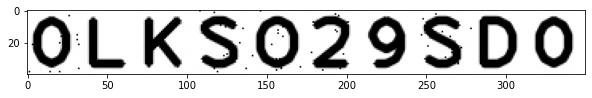

In [428]:
vis = cv2.imread('img_4.jpg')
img = cv2.imread('img_4.jpg', 0)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, cmap='gray')
plt.show()

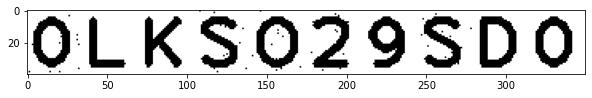

In [429]:
dst_adap = cv2.adaptiveThreshold(img, 255, 
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY,
                                 15, 7)
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(dst_adap, cmap='gray')
plt.show()

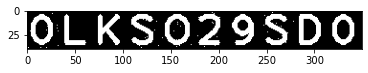

In [430]:
ret_o, dst_o = cv2.threshold(dst_adap, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(dst_o, cmap='gray')
plt.show()

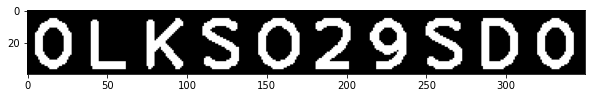

In [431]:
kernel = np.ones((2,2), dtype = np.uint8)

open = cv2.morphologyEx(dst_o, cv2.MORPH_OPEN, kernel, iterations=1)
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(open, cmap='gray')
plt.show()

In [432]:
bin_img = open

In [433]:
horp = np.sum(bin_img, axis=0) / 255
drawedhorp = tl.getDrawProjectionHor(img, horp)

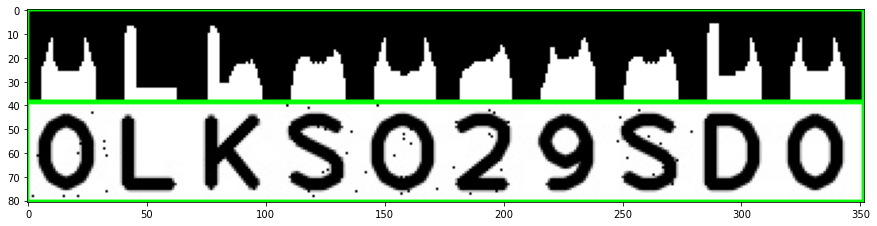

In [434]:
bigImg1 = tl.concat_ver((drawedhorp, img))
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(bigImg1, cmap='gray')
plt.show()

In [435]:
half = int(np.max(horp) / 2)
sliceLine = drawedhorp[:,(half-1):(half+1)]
contours, hierarchy = cv2.findContours(cv2.cvtColor(   sliceLine, 
                                                       cv2.COLOR_BGR2GRAY), 
                                                       cv2.RETR_EXTERNAL, 
                                                       cv2.CHAIN_APPROX_SIMPLE)

In [436]:
heights = []
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    heights.append(h)

In [437]:
medianHeight = int(np.median(np.asarray(heights)))
print("medianHeight", medianHeight)

medianHeight 12


In [438]:
drawedhorp = cv2.line(drawedhorp, 
                      (0, half), 
                      (drawedhorp.shape[1], half), 
                      (255,0,0), 
                      1)

In [439]:
kernel = medianHeight
horpConvolved = np.convolve(horp, np.ones((kernel,))/kernel, mode='same')
drawedhorpconv = tl.getDrawProjectionHor(bin_img, horpConvolved)

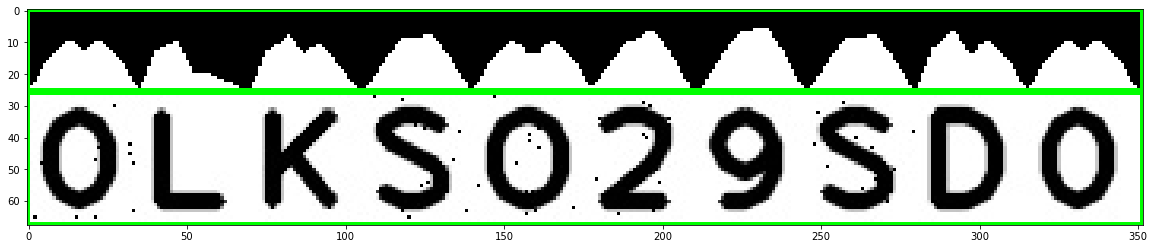

In [440]:
bigImg2 = tl.concat_ver((drawedhorpconv, img))
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(bigImg2, cmap='gray')
plt.show()

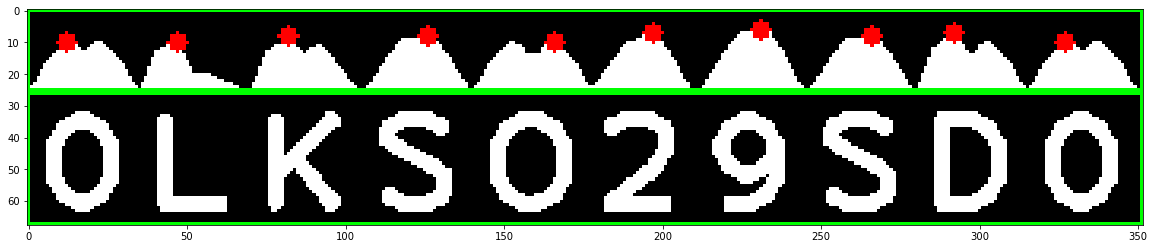

In [441]:
hor_bandP1ranges = []
hor_peaks = []
c1 = 0.29
c2 = 0.3
while np.max(horpConvolved) > 10 :
    xbm = np.argmax(horpConvolved)

    xb0 = tl.findb0(horpConvolved, 
                    xbm, 
                    c1 * horpConvolved[xbm])
    xb1 = tl.findb1(horpConvolved, 
                    xbm, 
                    c2 * horpConvolved[xbm])

    if xb1 - xb0 > medianHeight:
        hor_bandP1ranges.append((xb0,xb1))
        hor_peaks.append((int(horpConvolved[xbm]), xbm))

    horpConvolved[xb0:xb1] = 0
peaks_drawedhorpconv = drawedhorpconv.copy()
for peak in hor_peaks:
    cv2.circle(peaks_drawedhorpconv, (peak[1], peaks_drawedhorpconv.shape[0]-peak[0]), 3, (255,0,0), -1)
fig, ax = plt.subplots(figsize=(20, 20))
final_peaks = tl.concat_ver((peaks_drawedhorpconv, bin_img))
ax.imshow(final_peaks, cmap='gray')
plt.show()

In [442]:
drawedhorpconv.shape[0]

24

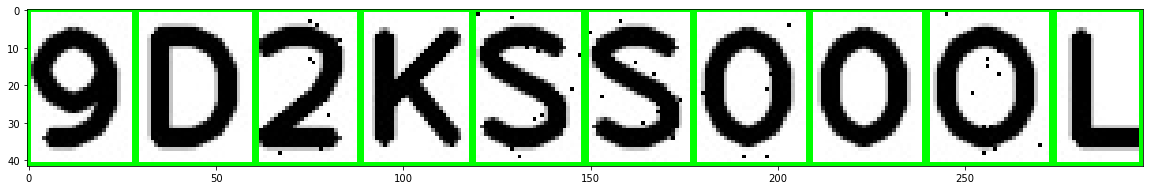

In [443]:
band_crop = []
for band in hor_bandP1ranges:
    xt, xb = band
    cropped = vis[:, xt:xb, ...]
    band_crop.append(cropped)
cropped = tl.concat_hor(band_crop)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(cropped, cmap='gray')
plt.show()

In [444]:
hor_bandsImg = np.zeros(vis.shape, dtype = np.uint8)

for band in hor_bandP1ranges:
    xt, xb = band
    hor_bandsImg[:, xt:xb, ...] = [125,0,0]

In [445]:
hor_vis = cv2.addWeighted(vis, 0.6, hor_bandsImg, 0.4, 0)
drawedhorpconv = cv2.addWeighted(drawedhorpconv, 0.6, hor_bandsImg[0:drawedhorpconv.shape[0], ...], 0.4, 0)

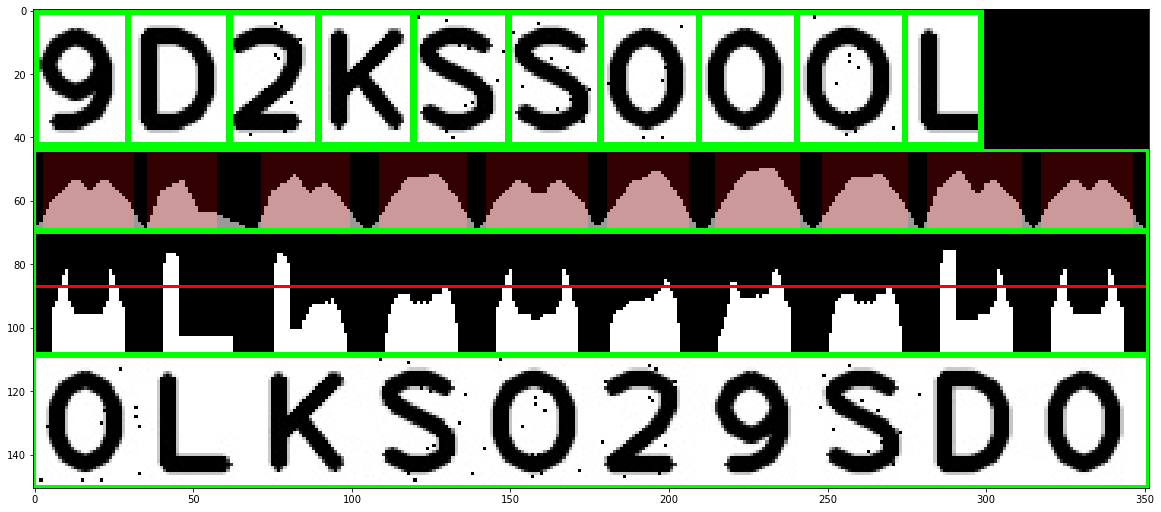

In [446]:
bigImg1 = tl.concat_ver((cropped, drawedhorpconv, drawedhorp, vis))
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(bigImg1, cmap='gray')
plt.show()

## Second method

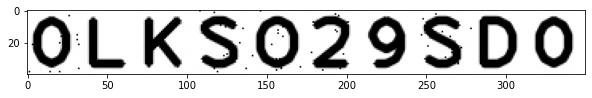

In [448]:
vis = cv2.imread('img_4.jpg')
img = cv2.imread('img_4.jpg', 0)
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(img, cmap = 'gray')
plt.show()

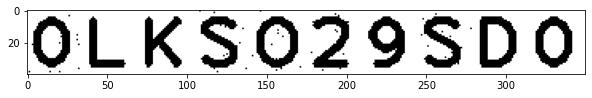

In [449]:
dst_adap = cv2.adaptiveThreshold(img, 255, 
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY,
                                 15, 7)
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(dst_adap, cmap='gray')
plt.show()

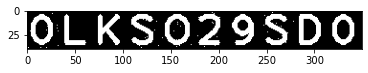

In [450]:
ret_o, dst_o = cv2.threshold(dst_adap, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(dst_o, cmap='gray')
plt.show()

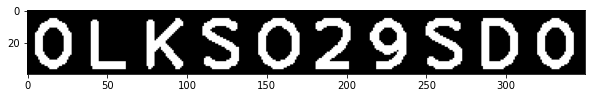

In [451]:
kernel = np.ones((2,2), dtype = np.uint8)

open = cv2.morphologyEx(dst_o, cv2.MORPH_OPEN, kernel, iterations=1)
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(open, cmap='gray')
plt.show()

In [452]:
contours, hier = cv2.findContours(open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

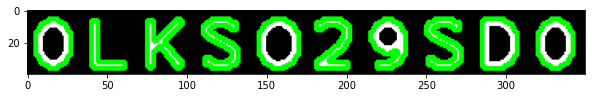

In [453]:
vis = cv2.cvtColor(open, cv2.COLOR_GRAY2BGR)
img_cnts = cv2.drawContours(vis, contours, -1, (0,255,0), 2)
fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(img_cnts, cmap='gray')
plt.show()

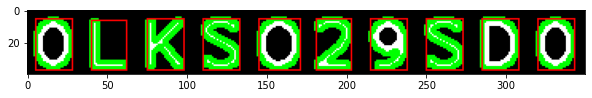

In [454]:
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(img_cnts, (x,y), (x+w, y+h), (255,0,0), 1)

fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(img_cnts, cmap='gray')
plt.show()

In [455]:
print(len(contours))

10
